# Load Data

In [3]:
# The goal of this predictive analysis is to be able to take predict the if someone is likely to have
# Heart Disease or not.

import pandas as pd

# First step it to load data into a dataframe
# The header is set to be the first row of the dataset
# The file is a semi-colon separated file, so we'll set sep=';'
heart_disease_df = pd.read_csv('heart_disease.csv', header=[0], sep=';')

# Data Transformation

In [4]:
# Some of the column names are a little bit ambiguous, so they will be fleshed out a little bit.
"""
According to the dataset:
- 'ap_hi' is the 'Systolic Blood Pressure',
- 'ap_lo' is the 'Diastolic Blood pressure',
- 'smoke' identifies whether they're a smoker or not.
- 'cardio' is the presence or absence of 'Cardiovasculaer Disease',
- 'alco' means 'Alcohol Intake',
- 'gluc' means 'Glucose Levels'
"""
# We'll use inplace set to True to replace the df instead of creating a new one
heart_disease_df.rename(columns={'ap_hi': 'systolic_bp', 'ap_lo': 'diastolic_bp', 'gluc': 'glucose', 'smoke': 'smoker', 'alco': 'alcohol_intake', \
                                 'cardio': 'heart_disease'}, inplace=True)

In [9]:
# Predictions can't be made if there are missing values in the rows, so first check if there are any missing values.
any_missing_values = heart_disease_df.isnull().any().any()
print(any_missing_values)

False


# Feature Engineering

In [19]:
# For this prediction, the label will be the heart_disease column. So get rid of the id column as it has no effect on the label.
heart_disease_df_2 = heart_disease_df.drop(['id'], axis=1, inplace=False)

# Now for the Features and Corresponding Labels
# Axis set to 1 means drop columns as opposed to dropping rows
X = heart_disease_df_2.drop(['heart_disease'], axis=1)
y = heart_disease_df_2['heart_disease']
print(f"FEATURES: \n {X} \n\n LABELS: \n {y}")

FEATURES: 
          age  gender  height  weight  systolic_bp  diastolic_bp  cholesterol  \
0      18393       2     168    62.0          110            80            1   
1      20228       1     156    85.0          140            90            3   
2      18857       1     165    64.0          130            70            3   
3      17623       2     169    82.0          150           100            1   
4      17474       1     156    56.0          100            60            1   
...      ...     ...     ...     ...          ...           ...          ...   
69995  19240       2     168    76.0          120            80            1   
69996  22601       1     158   126.0          140            90            2   
69997  19066       2     183   105.0          180            90            3   
69998  22431       1     163    72.0          135            80            1   
69999  20540       1     170    72.0          120            80            2   

       glucose  smoker  alc

In [22]:
"""
# To ensure the best quality features, Principal Component Analysis (PCA) will be applied.
# This is a process whereby the features are first standardized to a given scale, a covariance matrix is then created to understand how different
features relate to one another. Next eigendecomposition is done to get a set of eigenvectors and eigenvalues. The eigenvectors indicate
the direction in which the data varies most, and the eigenvalues indicate the magnitude of the variance in that given direction. The eigenvectors
are sorted in descending order based on their eigenvalues, and the top eigenvectors are selected given that they represent the components with the most
amount of variance. The original data is then projected onto the new feature space formed by the selected principal components.
This transformation results in a new set of uncorrelated features, which is the goal of PCA.
"""
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = StandardScaler().fit_transform(X)
pca = PCA(n_components=11)
X2 = pca.fit_transform(X)

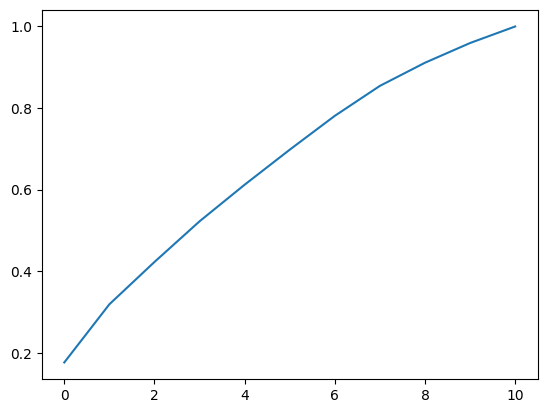

In [24]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Not all the components may be required to explain a large percentage of the variance in the dataset.
# To check the contribution of each component the cumulatice sum of the explained variance will be looked at both in matrix and graph form below.
np.set_printoptions(suppress=True)

# Matrix
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

# Graph
plt.plot(pc_vs_variance)
# The lack of an elbow point in the cumulative explained variance graph suggests a somewhat consistent level of contribution across the components

# Supervised Machine Learning

In [25]:
"""
The model chosen to be trained is the Bagging Meta-estimator because of it's efforts in reducing overfitting and the variance of the base estimators,
improving the stability and robustness of the ensemble. More on that here ==>
https://www.linkedin.com/advice/1/what-pros-cons-using-ensemble-methods-ml-skills-algorithms
"""
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
"""
Now prepare the data by splitting it into two parts. One part will be used for training the classifier into a suitable
model to make predictions, and the remaining samples will be used as test samples to make predictions and test the newly formed model.
"""
# Sidenote:Random_state controls the shuffling applied to the data before applying the split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Now fit PCA on the training data
pca = PCA(n_components=11)
X_train_2 = pca.fit_transform(X_train)
"""
How the model works: Bagging, or bootstrap aggregating, involves creating multiple models from different subsets of the training data, and then averaging
or voting their predictions. The 'max_samples' parameter is the max number of samples to pull from X to train each base estimator. The 'max_features' parameter is the number
of features to use to train each base estimator. Because the numbers passed in are floats (0.5) as opposed to integers it'll use 50% of the samples and 50% of the features.
KNeighborsClassifier is the base estimator to fit on random subsets of the dataset, it works by finding the k nearest neighbour(s) the
new data point is closest to, and uses their classes to predict what the class of the new data point should be.
"""

bagging_clf = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

# Now to train the model based on the trained data
bagging_clf.fit(X_train_2,y_train)

BaggingClassifier(estimator=KNeighborsClassifier(), max_features=0.5,
                  max_samples=0.5)

In [26]:
"""
Now for some predictions. But first transform X_test into the new feature space.
It's generally recommended to apply the same dimensionality reduction (PCA transformation) to both
the training and test datasets to ensure consistency in the feature representation.
"""
X_test_2 = pca.transform(X_test)

bagging_clf.predict(X_test_2)

array([1, 1, 1, ..., 1, 1, 0])

In [27]:
# Now the .score() method is used to calculate the accuracy of the model. The method compares the predictions for X_test_2 with their true values.
bagging_clf.score(X_test_2, y_test)

0.654

In [32]:
# The accuracy is around 0.65 which is really low, the goal is for it to be at the very least 0.7, (and of course the higher the better).
# Trying a different model, Logistic Regression, an accuracy score of around 0.72 is obtained, so it seems like a better choice.
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression(random_state=0).fit(X_train_2, y_train)
logreg_clf.predict(X_test_2)
logreg_clf.score(X_test_2, y_test)

0.7235

In [36]:
# Now one more to if a higher score can be obtained.
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10, 5), random_state=1, max_iter=300)

mlp_clf.fit(X_train_2, y_train)
mlp_clf.predict(X_test_2)
# An accuracy score of about 0.74, marginal increase, but still a better result than the last two models.
mlp_clf.score(X_test_2, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.7371428571428571

In [ ]:
mlp_clf.predict(X_test_2)
# 0.73, marginal, but still a better result than the last two models.
mlp_clf.score(X_test_2, y_test)

0.7311428571428571

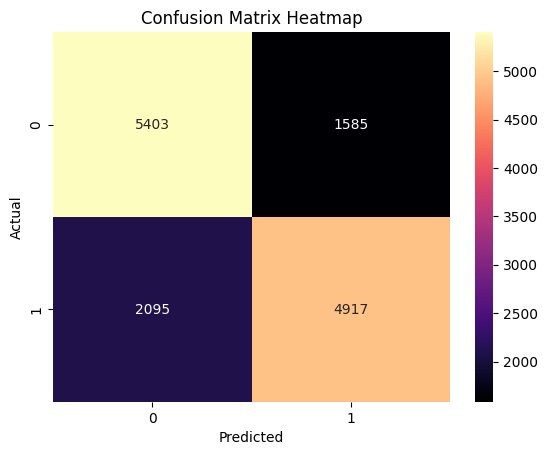

In [40]:
"""
A Confusion Matrix is created to understand the model a little better and see how likely it is to make accurate and inaccurate predictions
"""
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the matrix
y_pred = mlp_clf.predict(X_test_2)
cf_matrix = confusion_matrix(y_test, y_pred)

# Create the heatmap from the matrix
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="magma")

# Plot it with some additional information around it
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [49]:
"""
Now it's time to make a prediction:
There's a imaginary patient called Mark, born on April 6, 1982 (15,180 days old) male, who is about 178m tall, weighing in at about 112kg.
He has a systolic blood pressure of 110 and a diastolic blood pressure of 90. His cholestrol is normal, however his glucose levels are above normal.
He's not a smoker, he does drink a lot however, especially after rugby games. He plays a match almost every weekend and trains with the club every Tuesday
evening as well. He also frequents the gym each week too.
"""

from datetime import date

# Initial Data
marks_stats = {
    'birthday': '1982-06-04',
    'gender': 'M',
    'height': 178,
    'weight': 112.0,
    'systolic_bp': 110,
    'diastolic_bp':90,
    'cholesterol': 'normal',
    'glucose': 'normal',
    'smoker': False,
    'alcohol_intake': True,
    'active': True
}

#This is a predictor function to take in the patient's stats, do some necessary transformations and the make a prediction.
def mlp_heart_disease_predictor(patient_stats):
  # Convert the stats into a suitable format and reshape the result to the right dimensions
  nparray = np.array(stats_conversion(patient_stats)).reshape(1,11)

  # Apply PCA transformation
  patient_stats_pca=pca.transform(nparray)
  # Make prediction
  return mlp_clf.predict(patient_stats_pca)

def stats_conversion(raw_patient_stats):
  converted_stats = {
      'birthday':  get_days_from_bday(raw_patient_stats['birthday']),
      'gender': 1 if raw_patient_stats['gender'] == 'F' else 2,
      'height': raw_patient_stats['height'],
      'weight': raw_patient_stats['weight'],
      'systolic_bp': raw_patient_stats['systolic_bp'],
      'diastolic_bp': raw_patient_stats['diastolic_bp'],
      'cholesterol': get_cholesterol_index(raw_patient_stats['cholesterol']),
      'glucose': get_glucose_index(raw_patient_stats['glucose']),
      'smoker': 1 if raw_patient_stats['smoker'] else 0,
      'alcohol_intake': 1 if raw_patient_stats['alcohol_intake'] else 0,
      'active': 1 if raw_patient_stats['active'] else 0,
  }
  converted_stats_as_list = [value for key, value in converted_stats.items()]
  return converted_stats_as_list

def get_days_from_bday(original_birthday_input):
# Birthday - convert the date given into the Pythonic date format.
  bday_date = date(*map(int, original_birthday_input.split('-')))
  today_date = date.today()
  return (today_date - bday_date).days

def get_cholesterol_index(original_cholesterol_input):
  match original_cholesterol_input:
    case 'normal':
      return 1
    case 'above normal':
      return 2
    case 'well above normal':
      return 3

def get_glucose_index(original_glucose_input):
  match original_glucose_input:
    case 'normal':
      return 1
    case 'above normal':
      return 2
    case 'well above normal':
      return 3

mlp_heart_disease_predictor(marks_stats)


array([0])